# PL04. Linear Discriminant Analysis (LDA) in 5 Steps


### Performed by Víctor Vega Sobral
__Borja González Seoane. Machine Learning. Course 2024-25__

In this practice, a linear discriminant analysis (LDA) model will be implemented based on the 5-step specification available in the Unit II slides of the course \[Slides U2-S05\]. 

Objectives:

- **Implement LDA in 5 steps from scratch in Python, using only basic libraries like NumPy or Pandas**.
- Comment the code to relate theory and practice.
- Use an object-oriented archetype, as in PL03.
- Test with the Iris dataset.


In [86]:
import numpy as np
import pandas as pd
import matplotlib as plt 
 


In [87]:
TEST_SPLIT_SIZE = 0.3
RANDOM_STATE = 42

## Dataset loading

In [88]:
from ucimlrepo import fetch_ucirepo 


### Transform the species column to numeric

More convenient for subsequent analysis.

In [89]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
X_pd = iris["data"]["features"]
y_pd = iris["data"]["targets"]
 
X = np.array(X_pd)
y = np.array(y_pd)

In [ ]:
# Change the species columns to numeric 
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: "Setosa", 2: "Versicolor", 3: "Virginica"}

d:\Users\O M E N\miniconda3\envs\conda_env\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Users\O M E N\miniconda3\envs\conda_env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## LDA implementation in 5 steps

First, the different parts of LDA will be implemented in 5 steps. Then they will be coupled in an archetype class to be able to use it more easily.

### Step 1. Calculate the means of features for each class

In [ ]:
# THIS WOULD CALCULATE THE MEANS AT GLOBAL LEVEL 
# # Make a list with the keys(names) of the dataset columns
# features = ["sepal length", "sepal width", "petal length", "petal width"]

# for feature in features:
#     mean = X_pd[feature].mean()
#     print(f"The mean of {feature} is {mean}")



def calculate_vector_m(X, y, cl):
    m = np.mean(X[y == cl], axis = 0)
    return m 
    
m = calculate_vector_m(X, y, cl=1)

display(f"The mean for the class is {m}")


'La media para la clase es [5.006 3.418 1.464 0.244]'

### Step 2. Calculate the within-class and between-class scatter matrices

#### Within-class

In [ ]:
def calculate_within_class_scatter_matrix(X, y, cl, mv):
    class_sc_mat =np.zeros(
        (X.shape[1], X.shape[1])
    )

    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1)
        # Transform row vectors into column vectors

        class_sc_mat += (row -mv).dot((row-mv).T)

    return class_sc_mat
    
s_within_1 = calculate_within_class_scatter_matrix(X, y,1,m)
display(s_within_1)

array([[6.0882, 4.9146, 0.7908, 0.5168],
       [4.9146, 7.1138, 0.5724, 0.5604],
       [0.7908, 0.5724, 1.4752, 0.2792],
       [0.5168, 0.5604, 0.2792, 0.5632]])

#### Between-class

In [ ]:
def calculate_between_class_scatter_matrix(X, y, mv):
    global_mean = np.mean(X, axis = 0).reshape(4,1)

    s_between = np.zeros((X.shape[1], X.shape[1]))

    for cl in np.unique(y):
        n = X[y==cl].shape[0]
        s_between += n * (mv - global_mean).dot((mv - global_mean).T)

    return s_between


# Test 

s_between = calculate_between_class_scatter_matrix(X,y,m)
display(s_between)

array([[8567.16946667, 3026.9956    , 4426.60453333, -658.06746667],
       [3026.9956    , 2155.05      , 2375.3288    , 1575.0728    ],
       [4426.60453333, 2375.3288    , 2893.54066667, 1010.91666667],
       [-658.06746667, 1575.0728    , 1010.91666667, 3060.45266667]])

### Step 3. Calculate the eigenvectors and eigenvalues of the scatter matrix

In [ ]:
def calculate_eigen_matrix(s_within, s_between):
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(s_within).dot(s_between))

    for i in range(len(eig_vals)):
        eig_vec = eig_vecs[:, i].reshape(dim := s_between.shape[0],1)
        eig_val = eig_vals[i]
        A = np.linalg.inv(s_within).dot(s_between)
        np.testing.assert_array_almost_equal(
            A.dot(eig_vec),
            eig_val * eig_vec,
            decimal = 6,
            err_msg=f"Error in eigenvector {i}",

        )
        print(f"Eigenvectors and eigenvalues correct.")

        return eig_vals, eig_vecs
    
    

In [ ]:
# Quick test
eig_vals, eig_vecs = calculate_eigen_matrix(s_within_1, s_between)

display(eig_vals, eig_vecs)

Eigenvectores y eigenvalores correctos.


array([ 6.80526563e+03,  2.67382684e+03,  9.22487525e-13, -3.64893864e-13])

array([[-0.20387094, -0.39432456,  0.22827313,  0.07129948],
       [ 0.09090595,  0.19414259,  0.54270709, -0.83038789],
       [-0.11256764, -0.80946115, -0.80748249,  0.4724547 ],
       [ 0.96824649, -0.38934488,  0.03650226,  0.28663372]])

### Step 4. Select Fisher's discriminants

Sort the eigenvectors according to their eigenvalues in descending order. A projection matrix $W$ is formed, of dimension $d \times k$, where $d$ is the number of features and $k$ is the number of classes minus one.

In [ ]:


def select_linear_discriminants(eig_vals, eig_vecs, n_discriminants):
    eig_pairs = [((np.abs(eig_vals[i])), eig_vecs[:, i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    eig_vals_sum = sum(eig_vals)
    print(f"The variance explained by each linear discriminant is:")
    for pair_idx, pair in enumerate(eig_pairs):
        print(f"Pair {pair_idx} {(pair[0] / eig_vals_sum).real:.2%}")

    dim = eig_vecs.shape[0]
    W = np.hstack([eig_pairs[i][1].reshape(dim, 1) for i in range(n_discriminants)])
    
    return W



# Quick test
W = select_linear_discriminants(eig_vals, eig_vecs, 2)
display(W)

La varianza explicada por cada discriminante lineal es:
Par 0 71.79%
Par 1 28.21%
Par 2 0.00%
Par 3 0.00%


array([[-0.20387094, -0.39432456],
       [ 0.09090595,  0.19414259],
       [-0.11256764, -0.80946115],
       [ 0.96824649, -0.38934488]])

### Step 5. Use the projection matrix $W$ to project the original features

In [ ]:
def project_data(X, W):
    return (Y := X.dot(W))


display(project_data(X,W))

array([[-6.85516375e-01, -2.54267078e+00],
       [-6.90195161e-01, -2.56087716e+00],
       [-6.19983019e-01, -2.36223762e+00],
       [-6.31200048e-01, -2.50411165e+00],
       [-6.56038686e-01, -2.48382407e+00],
       [-5.50436271e-01, -2.90401843e+00],
       [-4.95846850e-01, -2.40385725e+00],
       [-6.85476640e-01, -2.60359870e+00],
       [-5.97350286e-01, -2.38312914e+00],
       [-7.89185980e-01, -2.58347453e+00],
       [-7.39753232e-01, -2.70308575e+00],
       [-6.55959216e-01, -2.60567990e+00],
       [-7.66632717e-01, -2.48251022e+00],
       [-6.30926954e-01, -2.04250959e+00],
       [-7.60259531e-01, -2.55973445e+00],
       [-5.43631051e-01, -2.76335228e+00],
       [-5.05409215e-01, -2.58023397e+00],
       [-5.88691726e-01, -2.58160527e+00],
       [-7.17512798e-01, -3.00279557e+00],
       [-5.72676705e-01, -2.60430861e+00],
       [-7.89538544e-01, -2.92322075e+00],
       [-4.84942651e-01, -2.66265735e+00],
       [-5.29463254e-01, -2.00230978e+00],
       [-4.

## Class archetype

A class that encapsulates the 5-step LDA process is implemented. It includes methods for training the model and for predicting new observations.

Public interface:

- `fit(X, y)`: Trains the model.
- `predict(X)`: Predicts the class of new observations.


In [ ]:
# Skeleton of the class to be implemented
class LDAClassifier5Steps:
    def __init__(self):  # Class constructor. Implement if necessary
        pass

    def fit(self, X: np.array, y: np.array):
        raise NotImplementedError("Implement this skeleton archetype")

    def predict(self, X: np.array) -> np.array:
        raise NotImplementedError("Implement this skeleton archetype")
    

In [ ]:
class LDAClassifier5Steps:
    def __init__(self, n_discriminants):
        self.n_discriminants = n_discriminants

    def fit(self, X: np.array, y: np.array):
        # Calculate the mean vectors for each class
        self.mv = np.array([self._calculate_vector_m(X, y, cl) for cl in np.unique(y)])
        
        # Calculate the within-class scatter matrix
        self.s_within = np.sum(
            [self._calculate_within_class_scatter_matrix(X, y, cl, mv) for cl, mv in zip(np.unique(y), self.mv)],
            axis=0
        )

        # Calculate the between-class scatter matrix
        self.s_between = self._calculate_between_class_scatter_matrix(X, y, self.mv[0])

        # Calculate the eigenvalues and eigenvectors
        self.eig_vals, self.eig_vecs = self._calculate_eigen_matrix(self.s_within, self.s_between)

        # Select linear discriminants
        self.W = self._select_linear_discriminants(
            self.eig_vals, self.eig_vecs, self.n_discriminants
        )

        # Project the data in the linear discriminants space
        self.X_proj = self._project(X, self.W)

        # Calculate the centroids of the classes in the transformed space
        self.centroids = np.array(
            [np.mean(self.X_proj[y == cl], axis=0) for cl in np.unique(y)]
        )

    def predict(self, X: np.array) -> np.array:
        # Project the new data in the linear discriminants space
        X_proj = self._project(X, self.W)

        # Classification based on distance to centroids
        y_pred = np.zeros(X_proj.shape[0])
        for i, x in enumerate(X_proj):
            y_pred[i] = np.argmin([np.linalg.norm(x - c) for c in self.centroids]) + 1
        
        return y_pred

    def _project(self, X, W):
        return X.dot(W)

    def _calculate_vector_m(self, X, y, cl):
        return np.mean(X[y == cl], axis=0)

    def _calculate_within_class_scatter_matrix(self, X, y, cl, mv):
        X_cl = X[y == cl]
        m_global = np.mean(X, axis=0).reshape(1, -1)
        return (X_cl - mv).T.dot(X_cl - mv)

    def _calculate_between_class_scatter_matrix(self, X, y, mv):
        m_global = np.mean(X, axis=0).reshape(1, -1)
        return (mv - m_global).T.dot(mv - m_global)

    def _calculate_eigen_matrix(self, s_within, s_between):
        return np.linalg.eig(np.linalg.inv(s_within).dot(s_between))

    def _select_linear_discriminants(self, eig_vals, eig_vecs, n_discriminants):
        # Sort eigenvectors according to eigenvalues
        idx = np.argsort(eig_vals)[::-1]
        eig_vecs = eig_vecs[:, idx]
        return eig_vecs[:, :n_discriminants]


## Final test with Iris

In [ ]:
# Split data into test and training sets with scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LDA classifier
n_discriminants = 3
lda_clf = LDAClassifier5Steps(n_discriminants)  
# Train the model
lda_clf.fit(X_train, y_train)  

# Make predictions on test data
y_pred = lda_clf.predict(X_test)



### Visualization of dimensionality reduction

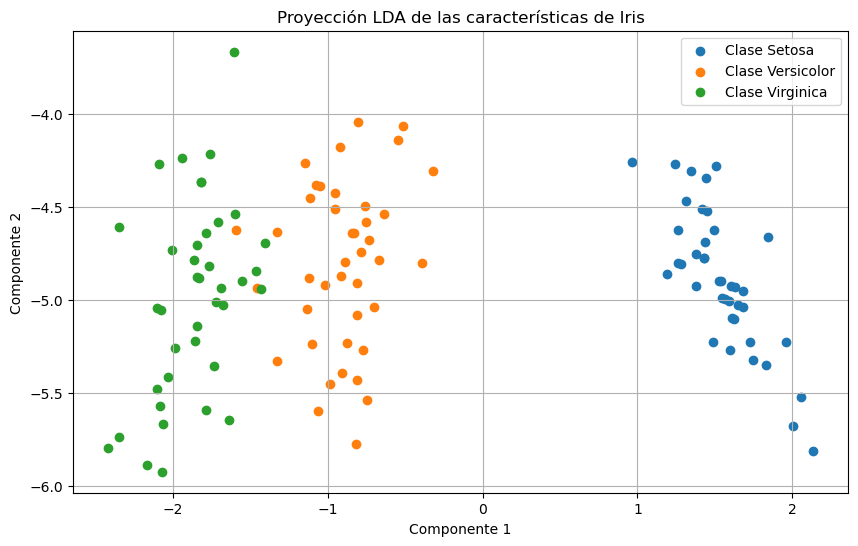

In [ ]:
import matplotlib.pyplot as plt


# Project training data to 2 dimensions
X_train_proj = lda_clf._project(X_train, lda_clf.W)

# Create a scatter plot
plt.figure(figsize=(10, 6))
for class_label in np.unique(y_train):
    plt.scatter(X_train_proj[y_train == class_label, 0], 
                X_train_proj[y_train == class_label, 1], 
                label=f'Class {label_dict[class_label]}')  
plt.title('LDA Projection of Iris Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()

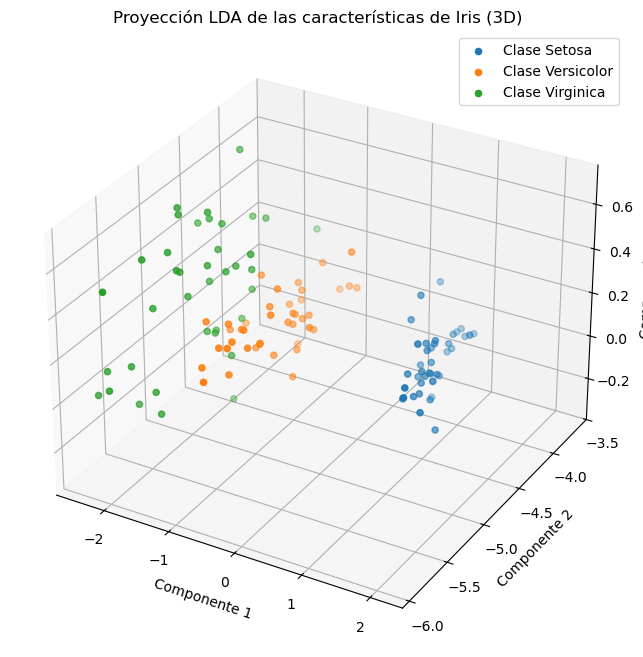

In [ ]:
X_train_proj_3d = lda_clf._project(X_train, lda_clf.W)  


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


for class_label in np.unique(y_train):
    ax.scatter(X_train_proj_3d[y_train == class_label, 0], 
               X_train_proj_3d[y_train == class_label, 1], 
               X_train_proj_3d[y_train == class_label, 2], 
               label=f'Class {label_dict[class_label]}') 

# Set titles and labels
ax.set_title('LDA Projection of Iris Features (3D)')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.show()

## Model evaluation

In this case the **accuracy** of the model is measured.

Use partitions for training and testing.

### In this section only the model accuracy is found. The partitions and training are in the "final iris test" section

In [ ]:
# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"LDA model accuracy: {accuracy * 100:.2f}%") 

Precisión del modelo LDA: 96.67%
